# Projeto final - SME0130 Redes Complexas

**Professor Francisco Rodrigues**

- **Arthur Vergaças Daher Martins | 12542672**
- **Gustavo Sampaio Lima | 12623992**
- **João Pedro Duarte Nunes | 12542460**
- **Pedro Guilherme dos Reis Teixeira | 12542477**

## Tópico escolhido:

<p style="text-align: center; font-size: 24px">3 – Como a cooperação é influenciada pela topologia da rede?</p>


In [1]:
import numpy as np
import networkx as nx
import random
from copy import deepcopy
from enum import Enum, auto
from typing import Self, Callable
import matplotlib.pyplot as plt

In [2]:
# Players can assume two strategies
class Strategy(Enum):
    COOPERATOR = auto()
    DEFECTOR = auto()

In [3]:
"""
There are 3 possible update rules a player can follow.

- Replicatior Dynamics: The player has a chance to start copying the strategy of one of its neighboors,
    the chance depends on how high the payoff of the neighboor is compared to the player.

- Unconditional Imitation: The player unconditionally copies the strategy of its more succesful neighboor if more succesful than itself.

- Moran Rule: The player has a chance of chance of copying any of its neighboors or keeping its strategy,
    this chance scales linearly according to the payoff of the player and neighboors.
"""


class UpdateRule(Enum):
    REP = auto()
    UI = auto()
    MOR = auto()

    def __str__(self) -> str:
        match self:
            case self.REP:
                return "Replicator Dynamics"
            case self.UI:
                return "Unconditional Imitation"
            case self.MOR:
                return "Moran rule"

    def update(
        self,
        player_node: int,
        players: list,
        network: nx.Graph,
        temptation_to_defect_payoff: float,
        handle_chosen_target: Callable,
    ):
        player = players[player_node]
        neighbors_indexes = [n for n in network.neighbors(player_node)]

        if len(neighbors_indexes) == 0:
            handle_chosen_target(player)
            return

        match self:
            case UpdateRule.REP:
                chosen_neighbor_index = random.choice(neighbors_indexes)
                chosen_neighbor = players[chosen_neighbor_index]

                player_degree = network.degree[player_node]  # type: ignore
                chosen_neighbor_degree = network.degree[chosen_neighbor_index]  # type: ignore

                probability_to_change = (
                    (chosen_neighbor.current_payoff - player.current_payoff)
                    / temptation_to_defect_payoff
                    * max(player_degree, chosen_neighbor_degree, 1)
                )

                if random.random() > probability_to_change:
                    handle_chosen_target(chosen_neighbor)
                else:
                    handle_chosen_target(player)

            case UpdateRule.UI:
                neighbors = [players[n] for n in neighbors_indexes]

                best_neighbor = max(neighbors, key=lambda n: n.current_payoff)

                if best_neighbor.current_payoff > player.current_payoff:
                    handle_chosen_target(best_neighbor)
                else:
                    handle_chosen_target(player)

            case UpdateRule.MOR:
                neighbors_indexes = [players[n] for n in neighbors_indexes]

                neighbors_and_player = [*neighbors_indexes, player]

                sum_of_payoffs = sum([p.current_payoff for p in neighbors_and_player])

                weights = [
                    p.current_payoff / max(sum_of_payoffs, 1)
                    for p in neighbors_and_player
                ]

                if all([w == 0 for w in weights]):
                    handle_chosen_target(player)
                    return

                chosen_target = random.choices(neighbors_and_player, weights=weights)[0]

                handle_chosen_target(chosen_target)

In [14]:
# NetworkX does not have a Non-linear Barabasi Albert Graph generator, this cell was used to implement one


def random_subset(seq: list, m: int, probabilities: None | list = None):
    """
    Return m elements of a sequence, probabilities for each element can de defined, if not uniform distribution is assumed.

    Differently from the usual np.random.choice de use of a set garantees that no repeated elements will be returned.
    """

    targets = set()
    while len(targets) < m:
        x = np.random.choice(seq, p=probabilities)
        targets.add(x)
    return targets


def normalize_prob(probabilities: list):
    """
    Given a list of probabilities they are normalized so that their sum is equal to 1
    """
    full_sum = sum(probabilities)
    normalized_probabilities = list(map(lambda x: x / full_sum, probabilities))
    return normalized_probabilities


def non_linear_barabasi_albert_graph(n, m, power=1, initial_graph=None):
    """
    Generates a random non-linear Barabasi Albert Graph.

    If power > 1 it generates a Superlinear Barabasi Albert Graph
    If power < 1 it generates a Sublinear Barabasi Albert Graph
    If power = 1 it generates a Linear Barabasi Albert Graph

    If no power is given it generates a Linear Barabasi Albert Graph
    """

    if m < 1 or m >= n:
        raise nx.NetworkXError(
            f"Barabási–Albert network must have m >= 1 and m < n, m = {m}, n = {n}"
        )
    if power <= 0:
        raise nx.NetworkXError(f"Power must not be zero or negative, power = {power}")

    if initial_graph is None:
        # Default initial graph : star graph on (m + 1) nodes
        G = nx.star_graph(m)
    else:
        if len(initial_graph) < m or len(initial_graph) > n:
            raise nx.NetworkXError(
                f"Barabási–Albert initial graph needs between m={m} and n={n} nodes"
            )
        G = initial_graph.copy()

    # Lists existing nodes, their degrees and their preference in the attachment according to the choosen power
    nodes = list(G.nodes)
    degrees = []
    probabilities = []
    for _, degree in sorted(G.degree(), key=lambda pair: pair[0]):
        degrees.append(degree)
        probabilities.append(pow(degree, power))

    # Start adding the other n - m0 nodes.
    source = len(G)
    while source < n:

        # Chooses m unique nodes from the existing ones following the preferential attachment
        targets = random_subset(nodes, m, normalize_prob(probabilities))
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))

        for target in targets:
            degrees[
                target
            ] += 1  # Increases the degree of each node which received a new connection
            probabilities[target] = pow(
                degrees[target], power
            )  # Gets the new preference for the node according to their new degree

        nodes.append(source)  # Adds source to the list of nodes
        degrees.append(m)  # Adds the degree of source to the list of degrees
        probabilities.append(
            pow(m, power)
        )  # Adds the preference of source to the list of probabilites

        source += 1
    return G

In [4]:
# 8 different types of networks are to be explored in the project
class NetworkType(Enum):
    ER = auto()
    WS_0 = auto()
    WS_005 = auto()
    WS_01 = auto()
    WS_03 = auto()
    BA = auto()
    SUB_BA = auto()
    SUPER_BA = auto()

    def __str__(self) -> str:
        match self:
            case self.ER:
                return "Erdős-Rényi Network Type"
            case self.WS_0:
                return "Watts-Strogatz (Small-World) Network Type (p = 0)"
            case self.WS_005:
                return "Watts-Strogatz (Small-World) Network Type (p = 0.05)"
            case self.WS_01:
                return "Watts-Strogatz (Small-World) Network Type (p = 0.1)"
            case self.WS_03:
                return "Watts-Strogatz (Small-World) Network Type (p = 0.3)"
            case self.BA:
                return "Barabási-Albert Network Type"
            case self.SUB_BA:
                return "Sublinear Barabási-Albert Network Type"
            case self.SUPER_BA:
                return "Superlinear Barabási-Albert Network Type"

    def generator_function(
        self, number_of_nodes: int, average_degree: float
    ) -> Callable[[], nx.Graph]:
        match self:
            case self.ER:
                return lambda: nx.fast_gnp_random_graph(
                    number_of_nodes, average_degree / (number_of_nodes - 1)
                )
            case self.WS_0:
                return lambda: nx.watts_strogatz_graph(
                    number_of_nodes, int(average_degree), 0
                )
            case self.WS_005:
                return lambda: nx.watts_strogatz_graph(
                    number_of_nodes, int(average_degree), 0.05
                )
            case self.WS_01:
                return lambda: nx.watts_strogatz_graph(
                    number_of_nodes, int(average_degree), 0.1
                )
            case self.WS_03:
                return lambda: nx.watts_strogatz_graph(
                    number_of_nodes, int(average_degree), 0.3
                )
            case self.BA:
                return lambda: nx.barabasi_albert_graph(
                    number_of_nodes, int(average_degree / 2)
                )
            case self.SUB_BA:
                return lambda: non_linear_barabasi_albert_graph(
                    number_of_nodes, int(average_degree / 2), power=0.5
                )
            case self.SUPER_BA:
                return lambda: non_linear_barabasi_albert_graph(
                    number_of_nodes, int(average_degree / 2), power=2
                )

In [5]:
class Player:
    def __init__(self, strategy: Strategy, update_rule: UpdateRule):
        self.strategy = strategy
        self.update_rule = update_rule
        self.current_payoff = 0

    # Method to facilitate the generation of random players
    @classmethod
    def from_fractions(
        cls,
        cooperators_fraction: float,
        rule_a_fraction: float,
        update_rules: list[UpdateRule],
    ) -> Self:
        strategy = random.choices(
            [Strategy.COOPERATOR, Strategy.DEFECTOR],
            weights=[cooperators_fraction, 1 - cooperators_fraction],
        )[0]

        update_rule = random.choices(
            update_rules, weights=[rule_a_fraction, 1 - rule_a_fraction]
        )[0]

        return cls(strategy, update_rule)

    def play_with(
        self,
        other: Self,
        temptation_to_defect_payoff: float,
        mutual_cooperation_payoff: float,
    ):
        # Following the weak prisoner's dillema (Nowak and May), which can be described in the following way:
        #
        #    | C | D |
        #  C | x | 0 |
        #  D | b | 0 |
        #
        # Where the rows indicate the player strategy, and the columns the adversary's.
        # x = Mutual Cooperation Payoff
        # b = Temptation to Defect Payoff
        # Usually x = 1, varying b and watching its effects is the purpose of this project.
        #

        if (
            self.strategy == Strategy.COOPERATOR
            and other.strategy == Strategy.COOPERATOR
        ):
            self.current_payoff += mutual_cooperation_payoff
        elif (
            self.strategy == Strategy.DEFECTOR and other.strategy == Strategy.COOPERATOR
        ):
            self.current_payoff += temptation_to_defect_payoff

    def evolve(
        self,
        self_node: int,
        players: list[Self],
        network: nx.Graph,
        temptation_to_defect_payoff: float,
    ):
        self.update_rule.update(
            self_node,
            players,
            network,
            temptation_to_defect_payoff,
            lambda target: self._copy(target),
        )

    def reset(self):
        self.current_payoff = 0

    def _copy(self, other: Self):
        self.strategy = other.strategy
        self.update_rule = other.update_rule

    def __repr__(self) -> str:
        return f"PLAYER: {self.strategy} | {self.update_rule} | payoff={self.current_payoff}"

In [6]:
# Simulates the prisoner's dillema storing in a list the state of the network for each iteration
def simulate_prisoners_dilemma(
    number_of_iterations=4000,
    number_of_players=2500,
    temptation_payoff=1.0,
    mutual_cooperation_payoff=1.0,
    cooperators_fraction=0.5,
    rule_a_fraction=0.5,
    update_rules=[UpdateRule.MOR, UpdateRule.UI],
    network_type: NetworkType = NetworkType.BA,
    average_network_degree=6,
):
    cooperators_fraction_at_iteration = (
        []
    )  # List of % of cooperators in the network for each iteration
    rule_a_fraction_at_iteration = (
        []
    )  # List of % of Rule A (The first update rule chosen) in the network for each iteration

    # Function to store the state of the network during each iteration
    def store_network_snapshot():
        number_of_cooperators = 0
        number_of_rule_a = 0
        for node in network:
            player = players[node]

            number_of_cooperators += player.strategy == Strategy.COOPERATOR
            number_of_rule_a += player.update_rule == update_rules[0]

        cooperators_fraction_at_iteration.append(
            number_of_cooperators / number_of_players
        )
        rule_a_fraction_at_iteration.append(number_of_rule_a / number_of_players)

    network = network_type.generator_function(
        number_of_players, average_network_degree
    )()

    players: list[Player] = [
        Player.from_fractions(cooperators_fraction, rule_a_fraction, update_rules)
        for _ in range(number_of_players)
    ]  # Players generated randomly according to the initial settings of the network

    store_network_snapshot()
    for _ in range(number_of_iterations):
        # Each player plays against all of its neighboors
        for node in network:
            player = players[node]
            neighbors = [players[n] for n in network.neighbors(node)]

            for adversary in neighbors:
                player.play_with(
                    adversary, temptation_payoff, mutual_cooperation_payoff
                )

        players_snapshot = [
            deepcopy(p) for p in players
        ]  # Copies the state of players so that evolution occurs in parallel

        # Evolve according to the neighboors
        for node in network:
            player = players[node]
            player.evolve(node, players_snapshot, network, temptation_payoff)

        store_network_snapshot()

        # Reset the payoffs for the next iteration
        for player in players:
            player.reset()

    return (
        np.array(cooperators_fraction_at_iteration),
        np.array(rule_a_fraction_at_iteration),
    )

In [7]:
# Simulates the prisoner's dilemma with different values for b, storing the final state of each network
def simulate_prisoners_dilemma_for_different_b(
    b_start_value=1.0,
    b_final_value=2.0,
    b_iterations=20,
    number_of_iterations=4000,
    number_of_players=2500,
    mutual_cooperation_payoff=1.0,
    cooperators_fraction=0.5,
    rule_a_fraction=0.5,
    update_rules=[UpdateRule.MOR, UpdateRule.UI],
    network_type: NetworkType = NetworkType.BA,
    average_network_degree=6,
):
    cooperators_fraction_at_end_of_simulation = []
    rule_a_fraction_at_end_of_simulation = []

    for b in np.linspace(b_start_value, b_final_value, b_iterations):
        cooperators_fractions, rule_a_fractions = simulate_prisoners_dilemma(
            number_of_iterations=number_of_iterations,
            number_of_players=number_of_players,
            temptation_payoff=b,
            mutual_cooperation_payoff=mutual_cooperation_payoff,
            cooperators_fraction=cooperators_fraction,
            rule_a_fraction=rule_a_fraction,
            update_rules=update_rules,
            network_type=network_type,
            average_network_degree=average_network_degree,
        )

        cooperators_fraction_at_end_of_simulation.append(cooperators_fractions[-1])
        rule_a_fraction_at_end_of_simulation.append(rule_a_fractions[-1])

    return (
        np.array(cooperators_fraction_at_end_of_simulation),
        np.array(rule_a_fraction_at_end_of_simulation),
    )

In [8]:
# Values which will be given to b for the simulations in the 8 network types
b_start = 1.0
b_end = 2.0
b_iter = 100

## Erdős-Rényi


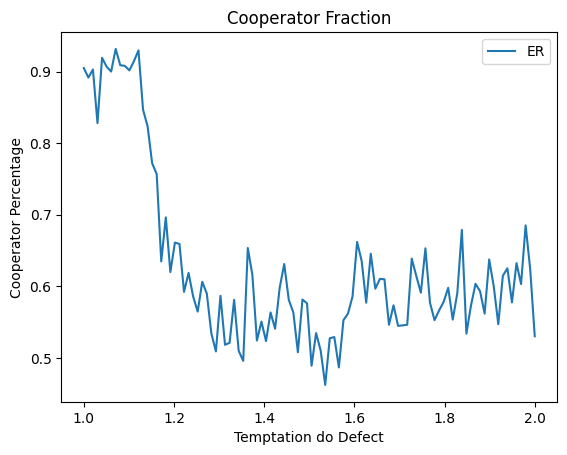

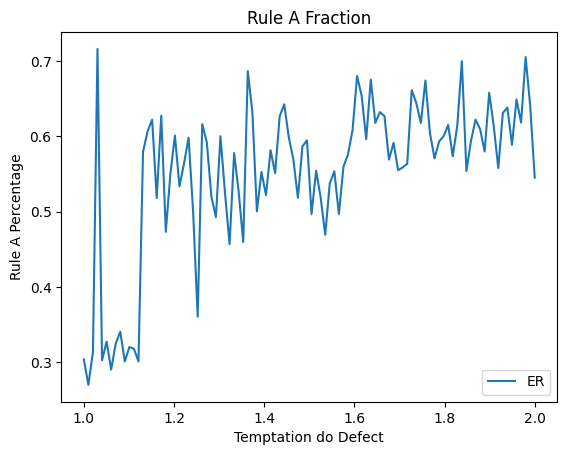

In [10]:
cooperators_fractions, rule_a_fractions = simulate_prisoners_dilemma_for_different_b(
    b_start_value=b_start,
    b_final_value=b_end,
    b_iterations=b_iter,
    number_of_iterations=100,
    average_network_degree=6,
    update_rules=[UpdateRule.REP, UpdateRule.UI],
    network_type=NetworkType.ER,
)


plt.plot(np.linspace(b_start, b_end, b_iter), cooperators_fractions, label="ER")
plt.xlabel("Temptation do Defect")
plt.ylabel("Cooperator Percentage")
plt.title("Cooperator Fraction")
plt.legend()
plt.show()

plt.plot(np.linspace(b_start, b_end, b_iter), rule_a_fractions, label="ER")
plt.xlabel("Temptation do Defect")
plt.ylabel("Rule A Percentage")
plt.title("Rule A Fraction")
plt.legend()
plt.show()

As it is possible to see in the images it's clear that for Erdős-Rényi graphs the existence of cooperation in the network
declines as the value of B increases, however notably the cooperation does not tend to fall over 50%, that's likely because
Defectors only benefit from interacting with Cooperators.

On the other hand the presence of the Rule A consistently grew.


## Watts-Strogatz


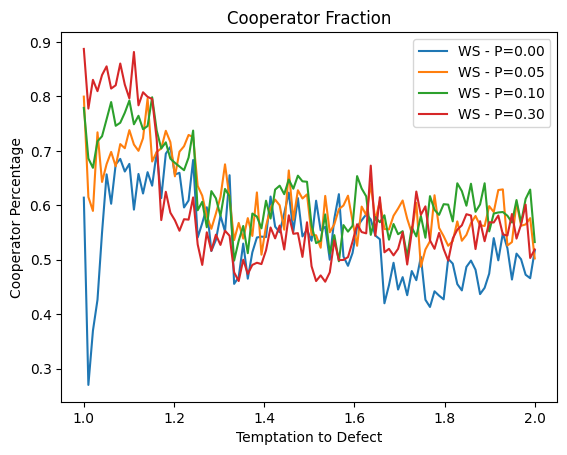

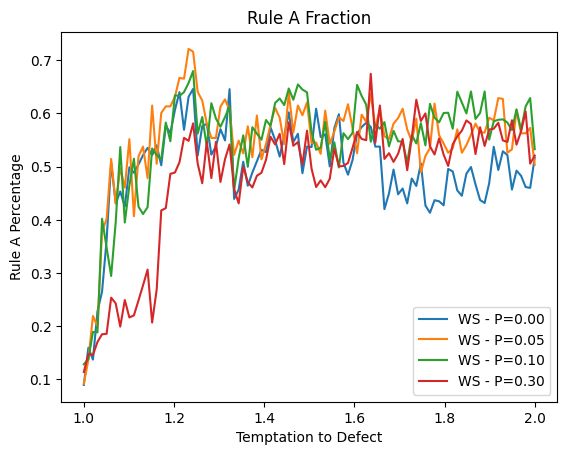

In [12]:
cooperators_fractions_0, rule_a_fractions_0 = (
    simulate_prisoners_dilemma_for_different_b(
        b_start_value=b_start,
        b_final_value=b_end,
        b_iterations=b_iter,
        number_of_iterations=100,
        average_network_degree=6,
        update_rules=[UpdateRule.REP, UpdateRule.UI],
        network_type=NetworkType.WS_0,
    )
)

cooperators_fractions_005, rule_a_fractions_005 = (
    simulate_prisoners_dilemma_for_different_b(
        b_start_value=b_start,
        b_final_value=b_end,
        b_iterations=b_iter,
        number_of_iterations=100,
        average_network_degree=6,
        update_rules=[UpdateRule.REP, UpdateRule.UI],
        network_type=NetworkType.WS_005,
    )
)

cooperators_fractions_01, rule_a_fractions_01 = (
    simulate_prisoners_dilemma_for_different_b(
        b_start_value=b_start,
        b_final_value=b_end,
        b_iterations=b_iter,
        number_of_iterations=100,
        average_network_degree=6,
        update_rules=[UpdateRule.REP, UpdateRule.UI],
        network_type=NetworkType.WS_01,
    )
)

cooperators_fractions_03, rule_a_fractions_03 = (
    simulate_prisoners_dilemma_for_different_b(
        b_start_value=b_start,
        b_final_value=b_end,
        b_iterations=b_iter,
        number_of_iterations=100,
        average_network_degree=6,
        update_rules=[UpdateRule.REP, UpdateRule.UI],
        network_type=NetworkType.WS_03,
    )
)

plt.plot(
    np.linspace(b_start, b_end, b_iter), cooperators_fractions_0, label="WS - P=0.00"
)
plt.plot(
    np.linspace(b_start, b_end, b_iter), cooperators_fractions_005, label="WS - P=0.05"
)
plt.plot(
    np.linspace(b_start, b_end, b_iter), cooperators_fractions_01, label="WS - P=0.10"
)
plt.plot(
    np.linspace(b_start, b_end, b_iter), cooperators_fractions_03, label="WS - P=0.30"
)
plt.xlabel("Temptation to Defect")
plt.ylabel("Cooperator Percentage")
plt.title("Cooperator Fraction")
plt.legend()
plt.show()

plt.plot(np.linspace(b_start, b_end, b_iter), rule_a_fractions_0, label="WS - P=0.00")
plt.plot(np.linspace(b_start, b_end, b_iter), rule_a_fractions_005, label="WS - P=0.05")
plt.plot(np.linspace(b_start, b_end, b_iter), rule_a_fractions_01, label="WS - P=0.10")
plt.plot(np.linspace(b_start, b_end, b_iter), rule_a_fractions_03, label="WS - P=0.30")
plt.xlabel("Temptation to Defect")
plt.ylabel("Rule A Percentage")
plt.title("Rule A Fraction")
plt.legend()
plt.show()

Graphs following the topology of Watts-Strogatz a similar robustness can be found,
there being a decline but not significantly bellow that of 50%. Interestingly the value of P seems most significant
for low values of B as there's a clear tendency that the high P is the higher the fraction of cooperators will be,
while as B increased all networks seemed to evolve in a similar way.

As for Rule A fraction despite the tests presenting less extreme variations the tendency appears similar to that of
Erdős-Rényi graphs, both tending to increase as B does.


## Barabási-Albert


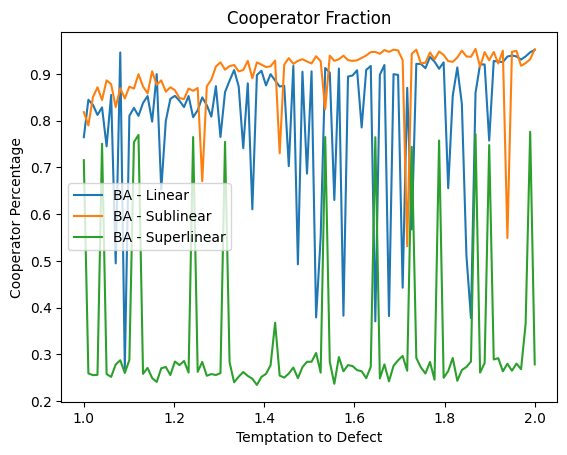

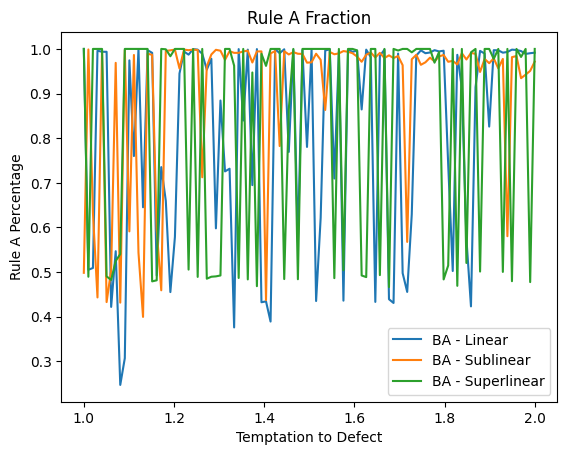

In [15]:
cooperators_fractions_BA, rule_a_fractions_BA = (
    simulate_prisoners_dilemma_for_different_b(
        b_start_value=b_start,
        b_final_value=b_end,
        b_iterations=b_iter,
        number_of_iterations=100,
        average_network_degree=6,
        update_rules=[UpdateRule.REP, UpdateRule.UI],
        network_type=NetworkType.BA,
    )
)

cooperators_fractions_SUB, rule_a_fractions_SUB = (
    simulate_prisoners_dilemma_for_different_b(
        b_start_value=b_start,
        b_final_value=b_end,
        b_iterations=b_iter,
        number_of_iterations=100,
        average_network_degree=6,
        update_rules=[UpdateRule.REP, UpdateRule.UI],
        network_type=NetworkType.SUB_BA,
    )
)

cooperators_fractions_SUPER, rule_a_fractions_SUPER = (
    simulate_prisoners_dilemma_for_different_b(
        b_start_value=b_start,
        b_final_value=b_end,
        b_iterations=b_iter,
        number_of_iterations=100,
        average_network_degree=6,
        update_rules=[UpdateRule.REP, UpdateRule.UI],
        network_type=NetworkType.SUPER_BA,
    )
)

plt.plot(
    np.linspace(b_start, b_end, b_iter), cooperators_fractions_BA, label="BA - Linear"
)
plt.plot(
    np.linspace(b_start, b_end, b_iter),
    cooperators_fractions_SUB,
    label="BA - Sublinear",
)
plt.plot(
    np.linspace(b_start, b_end, b_iter),
    cooperators_fractions_SUPER,
    label="BA - Superlinear",
)
plt.xlabel("Temptation to Defect")
plt.ylabel("Cooperator Percentage")
plt.title("Cooperator Fraction")
plt.legend()
plt.show()

plt.plot(np.linspace(b_start, b_end, b_iter), rule_a_fractions_BA, label="BA - Linear")
plt.plot(
    np.linspace(b_start, b_end, b_iter), rule_a_fractions_SUB, label="BA - Sublinear"
)
plt.plot(
    np.linspace(b_start, b_end, b_iter),
    rule_a_fractions_SUPER,
    label="BA - Superlinear",
)
plt.xlabel("Temptation to Defect")
plt.ylabel("Rule A Percentage")
plt.title("Rule A Fraction")
plt.legend()
plt.show()

On the other hand, Barabási-Albert networks presented significantly different results depending
on their state of linearity. Linear and Sublinear Barabási-Albert present great robustness for
cooperation, in general placing much higher than the two previous topologies. However,
Superlinear Barabási-Albert shows the opposite result with average cooperative robustness lower
than any other topology.

As for the Rule A fraction, the results don't present great stability but the Sublinear
network appears to have a much more stable high value for the Rule A fraction while the
Superlinear one has an extremely erratic behavior. However it is of note that the
average value remains above 50% for all types of topologies.
